In [2]:
# For auto-reloading external modules see
# http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

import numpy
import observations.dimensions.one.sampling as observe

from defaults.plot import *

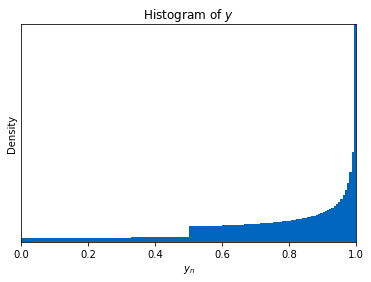

In [3]:
plt.hist(numpy.transpose(observe.sample(0))[0], bins = 150, density = True)
plt.title("Histogram of $y$")
plt.xlabel("$y_n$")
plt.ylabel("Density")
no_axis(x=True)
plt.savefig("figures/1d/density.pdf", dpi=dpi)
plt.show()

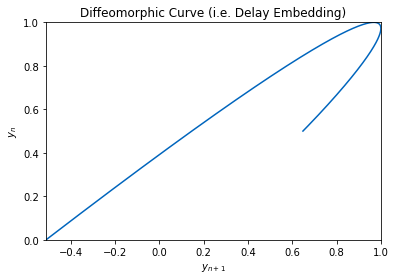

In [4]:
ys = observe.sample(1)

#plt.scatter(numpy.transpose(ys)[0], numpy.transpose(ys)[1], s = 0.5)
plt.title("Diffeomorphic Curve (i.e. Delay Embedding)")
plt.plot(numpy.transpose(ys)[1], numpy.transpose(ys)[0])
plt.xlabel('$y_{n+1}$')
plt.ylabel('$y_{n}$')
plt.savefig("figures/1d/diffeomorphic.pdf", dpi=dpi)
plt.show()

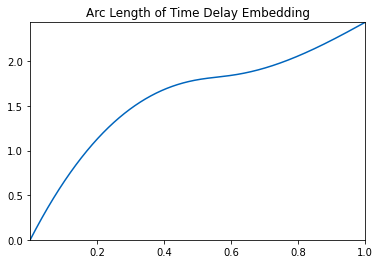

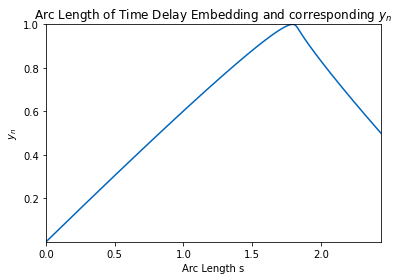

In [39]:
from observations.utils import arclen

alen = arclen([numpy.transpose(ys)[0], numpy.transpose(ys)[1]])

ys_0 = (numpy.transpose(ys)[0])[1:]
def y_by_s(s):
    #TODO: this could be done via interpolation, but we just search for the first one that is bigger
    return ys_0[numpy.argmax(alen >= s)]

y_by_s_vectorized = numpy.vectorize(lambda x: y_by_s(x))

plt.title("Arc Length of Time Delay Embedding") # linear on 0-1
plt.plot(numpy.linspace(0, 1, observe.samplesize)[1:], alen)
plt.savefig("figures/1d/arc-length.pdf", dpi=dpi)
plt.show()

plt.plot(alen, (numpy.transpose(ys)[0])[1:])
plt.title("Arc Length of Time Delay Embedding and corresponding $y_n$")
plt.xlabel('Arc Length s')
plt.ylabel('$y_n$')
plt.savefig("figures/1d/ys.pdf", dpi=dpi)
plt.show()

## This was mostly everything that is given by the sampling process and construction of the arc length $s$
We now learn the map from $s$ to $x$ (or vice versa) and can reconstruct the original curve and density

In [24]:
import flows.utils
import torch

flow_dist, transform = flows.utils.normal_to_samples(alen.reshape(-1, 1), steps=3001, lr=5e-3)
s_samples = flow_dist.sample(torch.Size([observe.samplesize])).detach().numpy()

step: 0, loss: 2.9297776222229004
step: 200, loss: 0.773989200592041
step: 400, loss: 0.6633816957473755
step: 600, loss: 0.6455980539321899
step: 800, loss: 0.6363692879676819
step: 1000, loss: 0.630529522895813
step: 1200, loss: 0.6266210079193115
step: 1400, loss: 0.6238811016082764
step: 1600, loss: 0.6218823790550232
step: 1800, loss: 0.6203785538673401
step: 2000, loss: 0.6192402243614197
step: 2200, loss: 0.6186776757240295
step: 2400, loss: 0.6174635887145996
step: 2600, loss: 0.6168970465660095
step: 2800, loss: 0.6165351271629333
step: 3000, loss: 0.6158323884010315


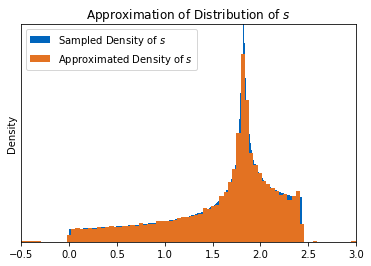

In [40]:
plt.title("Approximation of Distribution of $s$")
plt.hist(alen, bins=200, density=True, label="Sampled Density of $s$")
plt.hist(s_samples, bins=200, density=True, label='Approximated Density of $s$')
plt.ylabel("Density")
no_axis(x=True)
plt.xlim([-0.5, 3])
plt.legend()
plt.savefig("figures/1d/nf-arc-length.pdf", dpi=dpi)
plt.show()

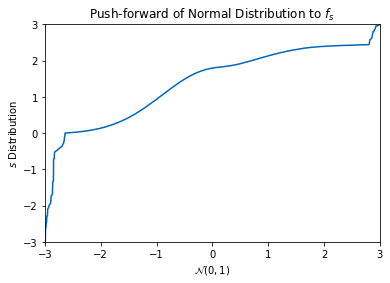

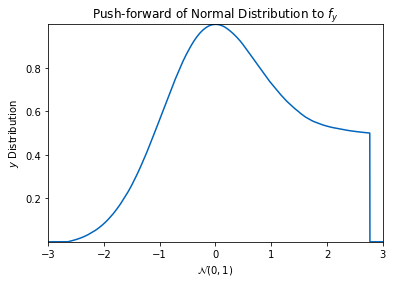

In [45]:
input = numpy.linspace(-3, 3, 10000)
mapped = transform(torch.tensor([[x] for x in input])).detach().numpy()

plt.title("Push-forward of Normal Distribution to $f_s$")
plt.plot(input, mapped)
plt.xlabel(r"$\mathcal{N}(0,1)$")
plt.ylabel("$s$ Distribution")
plt.savefig("figures/1d/normal-push-forward-arc-length.pdf", dpi=dpi)
plt.show()

plt.title("Push-forward of Normal Distribution to $f_y$")
plt.xlabel(r"$\mathcal{N}(0,1)$")
plt.ylabel("$y$ Distribution")
plt.plot(input, y_by_s_vectorized(mapped))
plt.savefig("figures/1d/normal-push-forward-y.pdf", dpi=dpi)
plt.show()

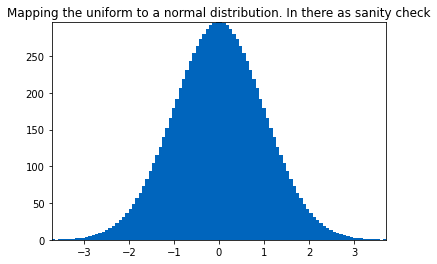

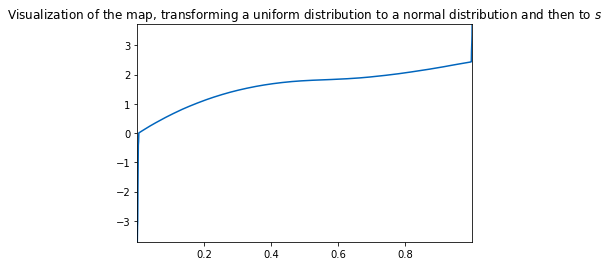

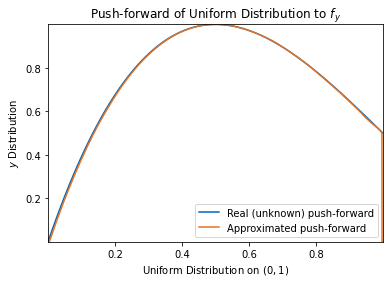

In [46]:
# We now look at the unifrom transported

from scipy.special import erfinv
input = numpy.linspace(0, 1, 10002)[1:-1] # the erfinv causes problems with the bounds, so we remove 0 and 1

Gauss = lambda x, mu, sigma: mu + numpy.sqrt(2)*sigma*erfinv(2*x-1)
standard_gauss = numpy.vectorize(lambda x: Gauss(x, 0, 1))

input_normal = standard_gauss(input)

# TODO delete? It is a good sanity check
plt.title("Mapping the uniform to a normal distribution. In there as sanity check")
plt.hist(input_normal, bins=100)
plt.show()

mapped = transform(torch.tensor([[x] for x in input_normal])).detach().numpy()

plt.title("Visualization of the map, transforming a uniform distribution to a normal distribution and then to $s$")
plt.plot(input, mapped)
plt.show()

plt.title("Push-forward of Uniform Distribution to $f_y$")
plt.plot(input, [observe.T(x) for x in input], label="Real (unknown) push-forward")
plt.plot(input, y_by_s_vectorized(mapped), label="Approximated push-forward")
plt.xlabel(r"Uniform Distribution on $\left( 0, 1 \right)$")
plt.ylabel("$y$ Distribution")
plt.legend()
plt.savefig("figures/1d/uniform-push-forward-y.pdf", dpi=dpi)
plt.show()

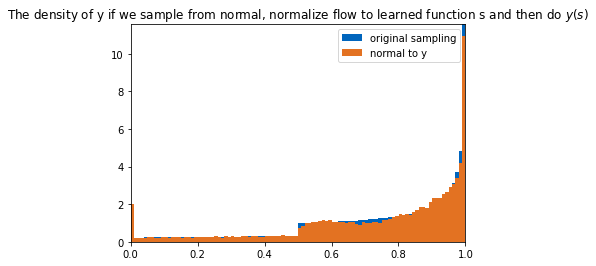

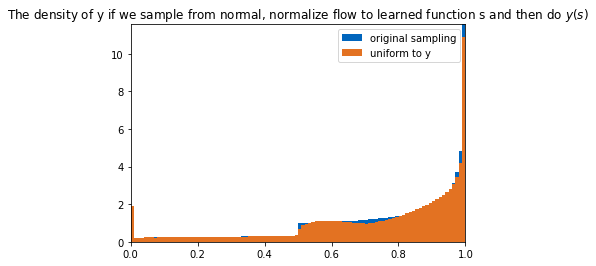

In [9]:
plt.title("The density of y if we sample from normal, normalize flow to learned function s and then do $y(s)$")
plt.hist(numpy.transpose(observe.sample(0))[0], bins = 100, density = True, label="original sampling")
plt.hist(y_by_s_vectorized(s_samples), bins=100, density=True, label="normal to y")
plt.legend()
plt.show()

plt.title("The density of y if we sample from normal, normalize flow to learned function s and then do $y(s)$")
plt.hist(numpy.transpose(observe.sample(0))[0], bins = 100, density = True, label="original sampling")
plt.hist(y_by_s_vectorized(mapped), bins=100, density=True, label="uniform to y")
plt.legend()
plt.show()

## Now we look into learning the dynamic on the arc length s

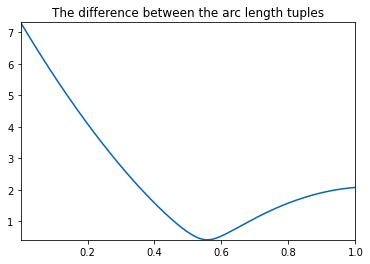

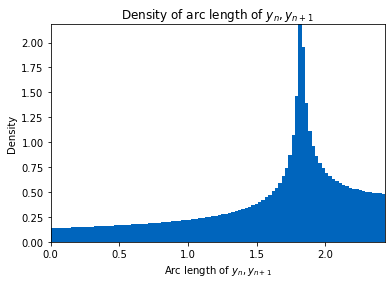

In [10]:
from observations.utils import lags

training_tuples = list(zip(*lags(arclen([numpy.transpose(ys)[0], numpy.transpose(ys)[1]]), 1)))

dt = 1 / observe.samplesize

real_difference = [abs(t0 - t1) / dt for t0, t1 in training_tuples]

plt.title("The difference between the arc length tuples") # TODO it  is not log scaled as of now
plt.plot(numpy.linspace(0, 1, observe.samplesize)[2:], real_difference)
plt.show()

s = arclen([numpy.transpose(ys)[0], numpy.transpose(ys)[1]])
plt.title("Density of arc length of $y_{n}, y_{n+1}$")
plt.hist(s, bins=100, density=True)
plt.xlabel("Arc length of $y_{n}, y_{n+1}$")
plt.ylabel("Density")
plt.show()

In [58]:
import dynamics.nets as nets
import dynamics.utils
import torch.nn as nn
from scipy.integrate import solve_ivp

def f(t, y):
    return model.one_step(torch.FloatTensor([y])).detach().numpy()[0]

def s_n1(model, s_n):
    return model(torch.tensor([[s_n]]).float()).item()

def s_n1_tensor(model, s_n):
    return model(s_n.float())

def show_model(model):
    fitted_values = s_n1_tensor(model, torch.unsqueeze(torch.tensor(numpy.transpose(training_tuples)[0]), 1))
    training_tuples_fitted = torch.cat((torch.unsqueeze(torch.tensor(numpy.transpose(training_tuples)[0]), 1), fitted_values), 1).detach().numpy()

    difference = numpy.abs(training_tuples_fitted[:, 0] - training_tuples_fitted[:, 1]) / dt

    plt.title("Derivative of Arc Length $s$") #  $(s_n, s_{n+1}) -> | s_{n+1} - s_{n}|$
    plt.plot(numpy.linspace(0, 1, observe.samplesize)[2:], real_difference, label="Measured Samples")
    plt.plot(numpy.linspace(0, 1, observe.samplesize)[2:], difference, label="Neural Prediction") # given s_n calculate s_n+1
    no_axis(y=True)
    plt.xlabel("Position on curve $(y_{n+1}, y_n)$")
    plt.ylabel("Gradient")
    plt.legend()
    plt.savefig("figures/1d/s-dynamics-gradiant.pdf", dpi=dpi)
    plt.show()

    t_eval = numpy.linspace(0, observe.samplesize * dt, observe.samplesize)
    sol = solve_ivp(f, [0, observe.samplesize * dt], [0], t_eval=t_eval)

    plt.title("Arc Length of Time Delay Embedding")
    plt.plot(t_eval[1:], alen, label="Measured Samples")
    plt.plot(t_eval, sol.y[0], label="Integrated Neural Prediction")
    plt.ylabel("Arc Length")
    plt.xlabel("Position on curve $(y_{n+1}, y_n)$")
    no_axis(y=True)
    plt.legend()
    plt.savefig("figures/1d/s-dynamics-arc-length.pdf", dpi=dpi)
    plt.show()

    plt.title("Prediction of $s_{n+1}$ given $s_n$")
    plt.plot(numpy.linspace(0, s[-1], 1000), [s_n1(model, x) for x in numpy.linspace(0, s[-1], 1000)], label = "$i = 1$, $y_{n}, y_{n+1}$", color = "green")
    plt.xlabel("$s_{n}$")
    plt.ylabel("$s_{n+1}$")
    plt.show()

def train_model():
    model = nets.RK4N(input_size=1, num_param=1, hidden_size=20, h=dt, num_hidden_layers=2)

    criterion = nn.L1Loss()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, amsgrad=True)
    #optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
    train_loader, val_loader = dynamics.utils.training_validator_splitter(training_tuples, bs=300)

    # Losses
    train_losses = []
    val_losses = []
    min_val_loss = 1e100

    for epoch in range(1, 2500):  # loop over the dataset multiple times
        train_loss = 0.0
        for _, (inputs, labels) in enumerate(train_loader, 0):
            inputs = torch.unsqueeze(inputs, 1).float()
            labels = torch.unsqueeze(labels, 1).float()

            optimizer.zero_grad()

            outputs = model(inputs)

            loss = criterion(outputs, labels)
            loss.backward()

            optimizer.step()

            # For statistics
            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        val_loss = 0.0
        with torch.no_grad():
            for _, (inputs, labels) in enumerate(train_loader, 0):
                inputs = torch.unsqueeze(inputs, 1).float()
                labels = torch.unsqueeze(labels, 1).float()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        print('[Epoch: %3d] training loss: %.9f  validation loss: %.9f' %
                (epoch, train_loss, val_loss))

        if  val_loss < min_val_loss:
            min_val_loss = val_loss

            show_model(model)

        model.save("full_one_dimensional/non_normalized/" + str(epoch) + ".model")

    plt.plot(train_losses, label="training loss")
    plt.plot(val_losses, label="validation loss")
    plt.yscale("log")
    plt.legend()
    plt.show()

    return model

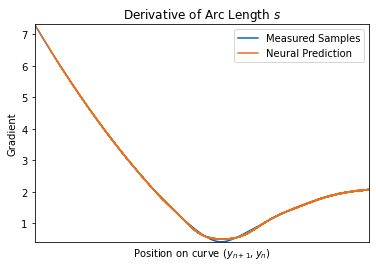

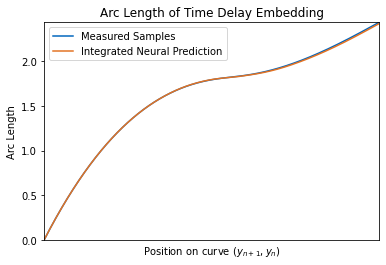

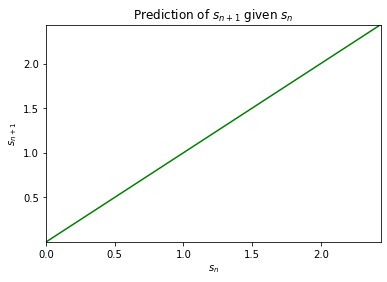

In [59]:
# To actually train the model use the following line:
# On my machine it took a while (about 30min?)
#model = train_model()

model = torch.load("models/1D-arclength-trained.model")
model.eval()

show_model(model)

0.0%
20.0%
40.0%
60.0%
80.0%


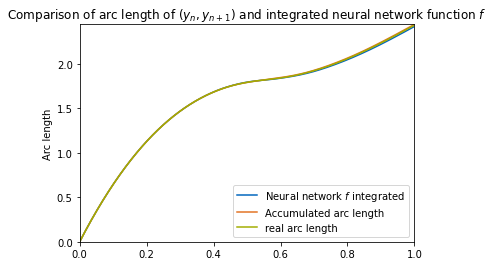

In [13]:
t_eval = numpy.linspace(0, observe.samplesize * dt, observe.samplesize)
sol = solve_ivp(f, [0, observe.samplesize * dt], [0], t_eval=t_eval)

acc = 0
accumulated_points = []
for i in range(observe.samplesize):
    accumulated_points.append(acc)
    acc = s_n1(model, acc)
    if i % 10000 == 0:
        print(str((i / observe.samplesize) * 100) + "%")

plt.title("Comparison of arc length of $(y_n, y_{n+1})$ and integrated neural network function $f$")
plt.ylabel("Arc length")
plt.plot(t_eval, sol.y[0], label="Neural network $f$ integrated")
plt.plot(t_eval, accumulated_points, label="Accumulated arc length")
plt.plot(t_eval[1:], alen, label="real arc length")
plt.legend()
plt.show()

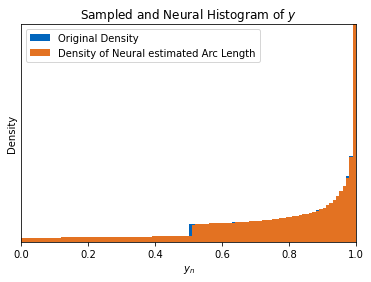

In [66]:
t_eval = numpy.linspace(0, observe.samplesize * dt, int(observe.samplesize))
sol = solve_ivp(f, [0, observe.samplesize * dt], [0], t_eval=t_eval)

# Comparison between original density of $y$ and neural reconstruction of $s$ transported with $y(s)$
plt.title("Sampled and Neural Histogram of $y$")
plt.hist(numpy.transpose(observe.sample(0))[0], bins = 100, density = True, label="Original Density")
new_ys = [y_by_s(s) for s in sol.y[0]]
plt.hist(new_ys, bins = 100, density = True, label="Density of Neural estimated Arc Length")
plt.legend(loc="upper left")
no_axis(x=True)
plt.ylabel("Density")
plt.xlabel("$y_n$")
plt.savefig("figures/1d/s-dynamics-density.pdf", dpi=dpi)
plt.show()

We could also use the integrated $f$ instead of the actual $s$ to learn to normalizing flow and then transport the density form x to y over s.